# Time Series Modeling Exercises

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import env

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Using saas.csv Split and Forecast Data

In [2]:
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
df.shape

(790458, 5)

In [4]:
df.dtypes

Month_Invoiced        object
Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
dtype: object

In [5]:
# for readability, make column names lower case
df.columns = df.columns.str.lower()
df.head()

,month_invoiced,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [6]:
df.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

In [7]:
df.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [8]:
# show that duplicates exist
df.customer_id.min(), df.customer_id.max()

(1000000, 1029399)

In [9]:
# shows 761K records with duplicate custome id
df[df.customer_id.duplicated()]

,month_invoiced,customer_id,invoice_id,subscription_type,amount
20000,2014-02-28,1000000,5020000,0.0,0.0
20001,2014-02-28,1000001,5020001,2.0,10.0
20002,2014-02-28,1000002,5020002,1.0,5.0
20003,2014-02-28,1000003,5020003,0.0,0.0
20004,2014-02-28,1000004,5020004,1.0,5.0
...,...,...,...,...,...
790253,2017-12-31,1029195,5790253,0.0,0.0
790254,2017-12-31,1029196,5790254,1.0,5.0
790255,2017-12-31,1029197,5790255,0.0,0.0
790256,2017-12-31,1029198,5790256,0.0,0.0


In [10]:
# check that invoice_id is in order and unique
df.invoice_id.min(), df.invoice_id.max()

(5000000, 5790457)

In [11]:
# check for nulls
df.isnull().sum()

month_invoiced       0
customer_id          0
invoice_id           0
subscription_type    0
amount               0
dtype: int64

In [12]:
# make column monthy_invoiced into datetime
df.month_invoiced = pd.to_datetime(df.month_invoiced)
df.dtypes

month_invoiced       datetime64[ns]
customer_id                   int64
invoice_id                    int64
subscription_type           float64
amount                      float64
dtype: object

In [13]:
# make month_invoiced into index and sort
df = df.set_index('month_invoiced').sort_index()
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [59]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [14]:
# remove other columsn because they give problems with function down stream
df = df[['amount']]
df.head()

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0


In [15]:
# amount only df for further analysis
invoiced = df[['amount']]
invoiced.head(20)

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,0.0


In [16]:
# show number of rcoes in one day. 
invoiced[(invoiced.index == '2014-01-31')] #20K records in one day

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0
...,...
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,0.0


In [17]:
# show records in day 2. Confirmes no invoiced amount
invoiced[(invoiced.index > '2014-01-31') & (invoiced.index < '2014-02-02')]

,amount
month_invoiced,


In [18]:
amount = df[['amount']]
amount.head()

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0


In [19]:
# resamaple by weekly mean
amount_weekly = amount.resample('W').mean()
amount_weekly.head() # show nulls in weekly units, don't use

,amount
month_invoiced,
2014-02-02,1.792500
2014-02-09,NaN
2014-02-16,NaN
2014-02-23,NaN
2014-03-02,1.878283


In [20]:
# resample by monthly mean
amount_monthly = amount.resample('M').mean()
amount_monthly.head()

,amount
month_invoiced,
2014-01-31,1.792500
2014-02-28,1.878283
2014-03-31,1.953926
2014-04-30,2.022099
2014-05-31,2.099527


<AxesSubplot:xlabel='month_invoiced'>

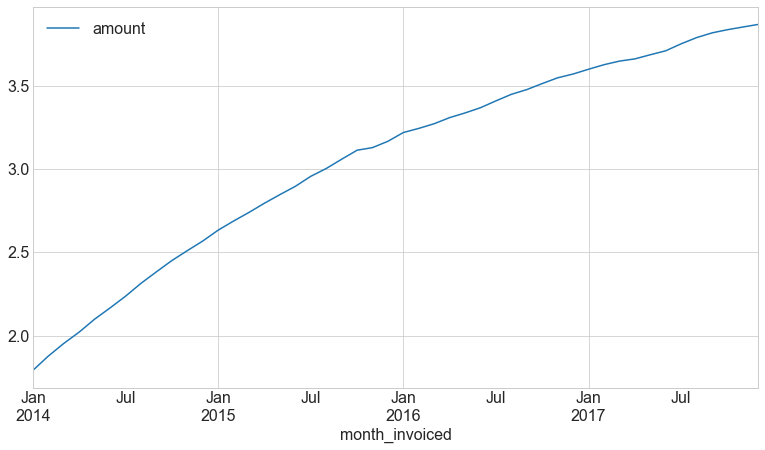

In [21]:
# plot amount overtime
amount_monthly.plot()

array([[<AxesSubplot:title={'center':'amount'}>]], dtype=object)

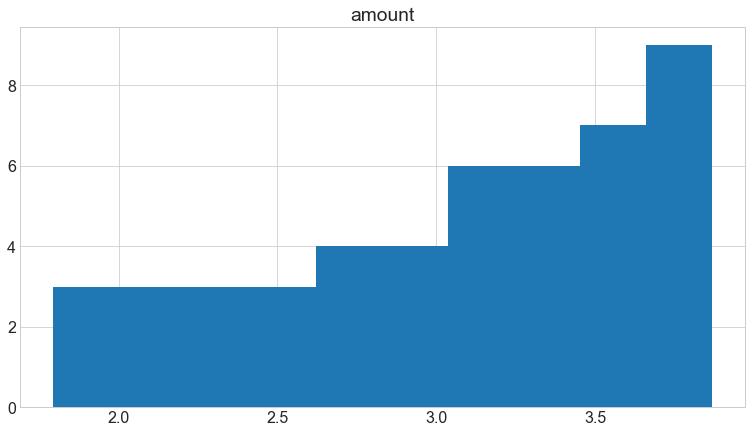

In [22]:
# plot amount distribution
amount_monthly.hist()

In [23]:
amount_monthly.index.min(), amount_monthly.index.max()

(Timestamp('2014-01-31 00:00:00', freq='M'),
 Timestamp('2017-12-31 00:00:00', freq='M'))

- Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [24]:
amount_monthly.head(), amount_monthly.tail()

(                  amount
 month_invoiced          
 2014-01-31      1.792500
 2014-02-28      1.878283
 2014-03-31      1.953926
 2014-04-30      2.022099
 2014-05-31      2.099527,
                   amount
 month_invoiced          
 2017-08-31      3.787740
 2017-09-30      3.816078
 2017-10-31      3.835197
 2017-11-30      3.851269
 2017-12-31      3.866969)

In [25]:
df.head()

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0


In [26]:
# spit into train, validate, test by months
train = df[:'2015']
validate = df['2016']
test = df['2017']
train.shape, validate.shape, test.shape

((431894, 1), (186275, 1), (172289, 1))

In [27]:
# verify split
print(len(train) + len(validate) + len(test) == len(df))

True


In [28]:
# confirm first row of df equals first row of train
print(df.head(1) == train.head(1))

                amount
month_invoiced        
2014-01-31        True


In [29]:
# Is the last row of train the day before the first row of validate?

In [30]:
pd.concat([train.tail(1), validate.head(1)])

,amount
month_invoiced,
2015-12-31,0.0
2016-01-31,5.0


In [31]:
# is the last row of validate the day before the first row of test?
pd.concat([validate.tail(1), test.head(1)])

,amount
month_invoiced,
2016-12-31,0.0
2017-01-31,5.0


In [32]:
train.index.min(), train.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [33]:
validate.index.min(), validate.index.max() #show 31jan of 2016 is first observation

(Timestamp('2016-01-31 00:00:00'), Timestamp('2016-12-31 00:00:00'))

In [34]:
test.index.min(), test.index.max()

(Timestamp('2017-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [60]:
type(train.index)

pandas.core.indexes.datetimes.DatetimeIndex

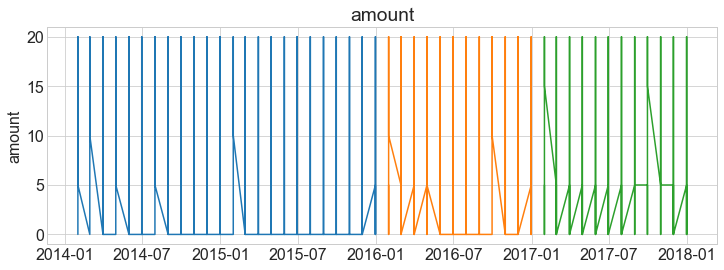

In [35]:
# plot split
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

### Create function to support evaluation and plotting

In [36]:
# create evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [37]:
# create plote that uses eval function to show train and test vlaues with the predicted vlaues in order to compare performance
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [38]:
# to append evaluation metrics for each model type, target variable, and metric type, along with the metric value

# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Simple Average

In [39]:
amount = round(train.amount.mean(),2)
amount

2.53

In [40]:
def make_predictions():
    yhat_df = pd.DataFrame({'amount':[amount]}, index=validate.index)
    return yhat_df

In [41]:
yhat_df = make_predictions()
yhat_df.head()

,amount
month_invoiced,
2016-01-31,2.53
2016-01-31,2.53
2016-01-31,2.53
2016-01-31,2.53
2016-01-31,2.53


amount -- RMSE: 5


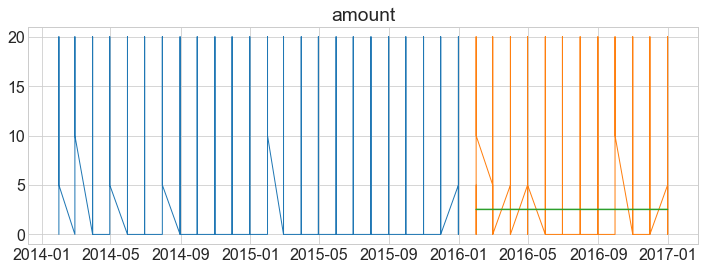

In [42]:
target_var = 'amount'
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label = 'Train', linewidth = 1)
plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df[target_var])
plt.title(target_var)
rmse = evaluate(target_var)
print(target_var, '-- RMSE: {:.0f}'.format(rmse))
plt.show()

amount -- RMSE: 5


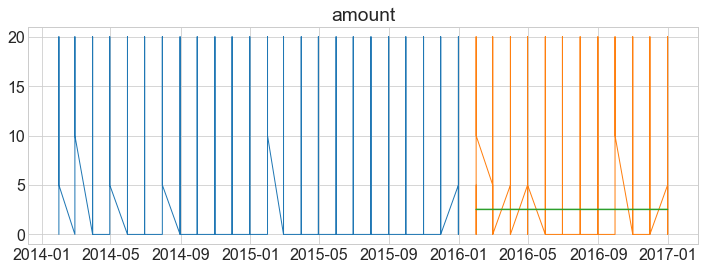

In [43]:
for col in train.columns:
    plot_and_eval(col)

amount -- RMSE: 5


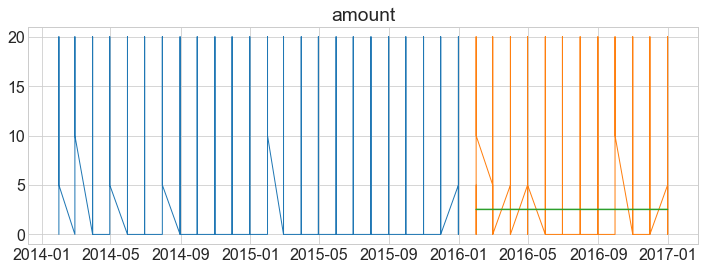

In [44]:
# plot prediction
for col in train.columns:
    plot_and_eval(col)

In [45]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
    
eval_df

,model_type,target_var,rmse
0,simple_average,amount,5.0


### Moving Average

In [46]:
# computer 30 day rolling average to predict forward
period = 30

amount = round(train.amount.rolling(period).mean().iloc[-1], 2)
amount

1.5

In [47]:
yhat_df = make_predictions()
yhat_df.head(3)

,amount
month_invoiced,
2016-01-31,1.5
2016-01-31,1.5
2016-01-31,1.5


amount -- RMSE: 5


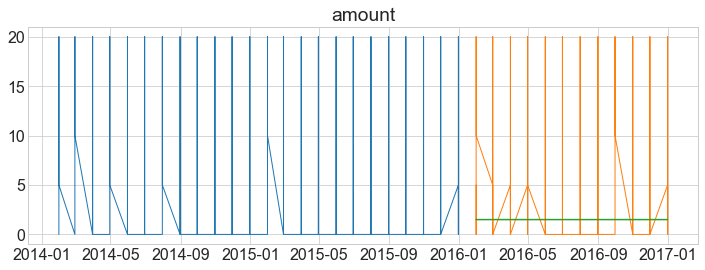

In [48]:
# plot prediction
for col in train.columns:
    plot_and_eval(col)

In [49]:
# look at prediction rmse
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,amount,5.0
1,30d moving average,amount,5.0


In [50]:
# test other period values
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    amount = round(train['amount'].rolling(p).mean().iloc[-1], 2)
    
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )
    
eval_df

,model_type,target_var,rmse
0,simple_average,amount,5.0
1,30d moving average,amount,5.0
2,1d moving average,amount,6.0
3,4d moving average,amount,6.0
4,12d moving average,amount,5.0
5,26d moving average,amount,5.0
6,52d moving average,amount,5.0
7,104d moving average,amount,5.0


### 1Day and 4Day Moving Average are worst

In [51]:
eval_df['rmse'].min()

5.0

In [52]:
# # get the min rmse for each variable

# min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
# min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

min_rmse_amount = eval_df['rmse'].min()

# # filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[eval_df.rmse == min_rmse_amount]

,model_type,target_var,rmse
0,simple_average,amount,5.0
1,30d moving average,amount,5.0
4,12d moving average,amount,5.0
5,26d moving average,amount,5.0
6,52d moving average,amount,5.0
7,104d moving average,amount,5.0


### Holt's Linear Trend

amount 



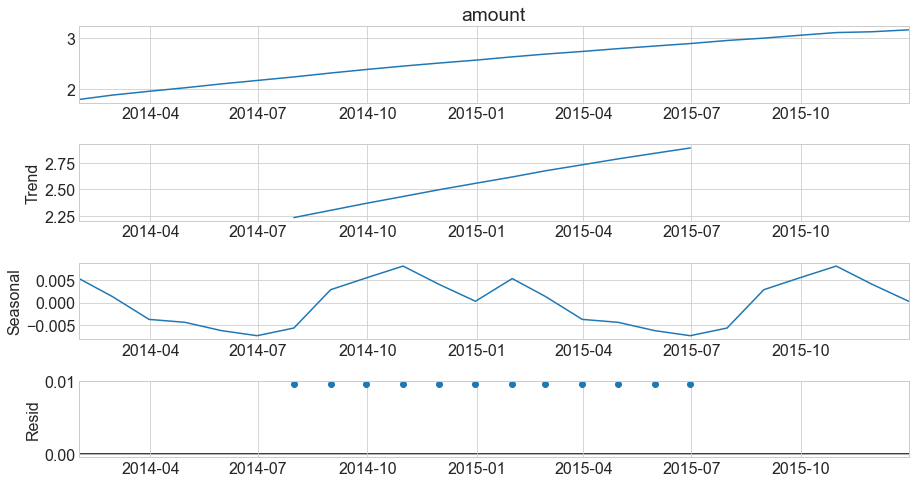

In [53]:
# take seasonal decomposition
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()


In [54]:
validate.index

DatetimeIndex(['2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31',
               ...
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31'],
              dtype='datetime64[ns]', name='month_invoiced', length=186275, freq=None)

In [55]:
validate.index[0]

Timestamp('2016-01-31 00:00:00')

In [56]:
validate

,amount
month_invoiced,
2016-01-31,5.0
2016-01-31,0.0
2016-01-31,5.0
2016-01-31,0.0
2016-01-31,0.0
...,...
2016-12-31,0.0
2016-12-31,0.0
2016-12-31,0.0


In [57]:
validate.index[0]

Timestamp('2016-01-31 00:00:00')

In [61]:
validate.index[-1]

Timestamp('2016-12-31 00:00:00')

In [63]:
model = Holt(train.amount, exponential=False)

model = model.fit(smoothing_level = .1,
                 smoothing_slope = .1,
                 optimized = False)

yhat_amount = model.predict(start = validate.index[0],
                           end = validate.index[-1])
round(yhat_amount, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

## Previous Cycle (Based on previous year/month/etc., this is up to you)

In [64]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [69]:
yhat_df = train['2015'] + train.diff(365).mean()
yhat_df.head()

,amount
month_invoiced,
2015-01-31,-0.000093
2015-01-31,9.999907
2015-01-31,-0.000093
2015-01-31,4.999907
2015-01-31,9.999907


In [66]:
pd.concat([yhat_df.head(1), validate.head(1)])

,amount
month_invoiced,
2015-01-31,-0.000093
2016-01-31,5.000000


In [67]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)


ValueError: Length mismatch: Expected axis has 204352 elements, new values have 186275 elements

ValueError: Found input variables with inconsistent numbers of samples: [186275, 204352]

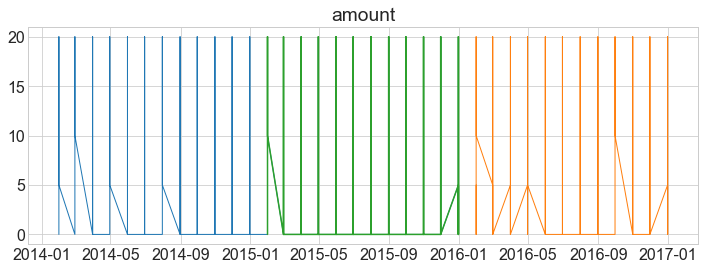

In [68]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

ValueError: Found input variables with inconsistent numbers of samples: [186275, 204352]

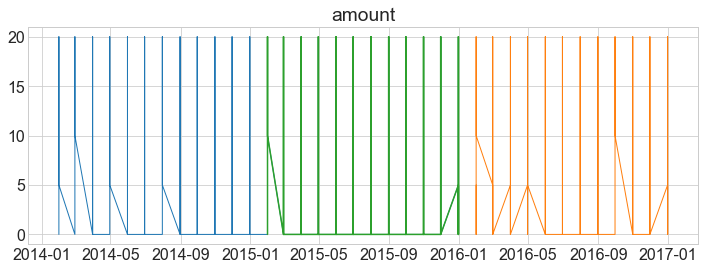

In [70]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)


# Optional: Using store item demand:

1. Predict 2018 total monthly sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.